# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import skimage
from skimage.draw import circle, polygon
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

coco_dir="/home/tianyu/mfs/google/lyg/coco/PythonAPI/"
sys.path.append(coco_dir)
sys.path.append("/home/tianyu/mfs/google/lyg/Mask_RCNN_test/Mask_RCNN/samples/coco/")  # To find local version

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


# Data Path
TRAIN_PATH = '/home/tianyu/mfs/google/lyg/seg_data/train/'
TEST_PATH = '/home/tianyu/mfs/google/lyg/seg_data/train/'

TRAIN_PATH2 = TRAIN_PATH

# Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids_ = next(os.walk(TEST_PATH+"image/"))[2]
test_ids = [ test_ids_[i].replace(".jpg","") for i in range(len(test_ids_)) ]

IMAGE_DIR = TEST_PATH


/mfs/tianyu/env/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Using TensorFlow backend.


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "whale"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024
    
    RPN_ANCHOR_RATIOS = [0.5, 3, 5]
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 1
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 10
    
##
    # If True, pad images with zeros such that they're (max_dim by max_dim)
    IMAGE_PADDING = True  # currently, the False option is not supported

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_NMS_THRESHOLD = 0.3 ####

    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.5 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 512
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 70
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE    

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    Extend the Dataset class and add a method to load the shapes dataset, 
    load_shapes(), and override the following methods:
    load_image()
    load_mask()
    image_reference()
    """
    def load_shapes(self,PATH):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # PATH=dir
        train_ids_ = next(os.walk(PATH+"/image/"))[2] 
        print("train_ids_,",train_ids_[0])
        train_ids = [ train_ids_[i].replace(".jpg","") for i in range(len(train_ids_)) ]
        count = len(train_ids)
        print("count,",count)
        print("train_ids,",train_ids[0])
        # Add classes
        # self.add_class("nuclei", 1, "nucleu")
        self.add_class("whales", 1, "whale")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). 
        for i in range(count):
            id_ = train_ids[i]
            # path_i = PATH + id_+ '/images/' + id_ + '.png'
            path_i = PATH+"/image/"+ id_+'.jpg'
            # self.add_image("nuclei", image_id=i, path=path_i)
            self.add_image("whales", image_id=i, path=path_i)

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # image = imread(self.image_info[image_id]['path'])[:,:,0:3]
        # image = resize(image, (256, 256), mode='constant', preserve_range = True)
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "whales":
            return info["whales"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        #test:  /home/tianyu/data-train/
        #image: /home/tianyu/mfs/google/lyg/seg_data/train/image/016791b76.jpg
        #mask : /home/tianyu/mfs/google/lyg/seg_data/train/mask/016791b76.png
        import_path=self.image_info[image_id]['path'].split('/')[3]
        if import_path !="data-train":
            # info = self.image_info[image_id]
            path = self.image_info[image_id]['path'].replace("/image/","/mask/")
            path = path.replace(".jpg",".png")
            # self.image_info[image_id]['path'].split('/')[0] +"/" + self.image_info[image_id]['path'].split('/')[1] + "/"
            # # print("load_mask_PATH:",PATH)
            # train_ids = next(os.walk(PATH))[1]
            # id_ = train_ids[image_id]
            # path = PATH + id_
            # count = len(next(os.walk(path + '/masks/'))[2])
            count = 1
            # mask = np.zeros([256, 256, count], dtype=np.uint8)
            # mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            # mask = np.expand_dims((skimage.io.imread(path,as_grey=True),axis=-1))
            mask = skimage.io.imread(path,as_grey=True)
#             print("mask_shape",mask.shape)
#             print("mask[0][0:10]",mask[0][0:10])
#             print("meanmask",np.mean(mask))
#             print("max",np.max(np.max(mask)))
#             print("min",np.min(np.min(mask)))
#             print("summask",np.sum(np.sum(mask)))
            _,mask = cv2.threshold(mask,0.45,1,cv2.THRESH_BINARY)
            # mask = mask.point(lambda x: 255 if x > 0.5 else 0)
#             mask = mask.convert('1')
            mask = np.expand_dims(mask,axis=-1)
            # Handle occlusions
            # each pixel in each 1st 2ed dim
#             occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
#             # 1 is blank in occlusion, 0 is image
#             for i in range(count-2, -1, -1):
#                 mask[:, :, i] = mask[:, :, i] * occlusion
#                 occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            # Map class names to class IDs.
#             print("mask_shape",mask.shape)
#             print("mask[0][0:10]",mask[0][0:10])
#             print("summask",np.sum(np.sum(mask)))
            class_ids = np.array([1 for s in range(count)])
            return mask, class_ids.astype(np.int32)
        else:
            pass

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(TRAIN_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(TRAIN_PATH2)
dataset_val.prepare()

train_ids_, 047604b6c.jpg
count, 450
train_ids, 047604b6c
train_ids_, 047604b6c.jpg
count, 450
train_ids, 047604b6c


summask 181846.0


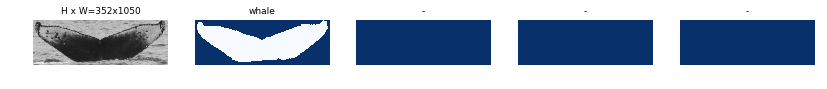

summask 30571.0


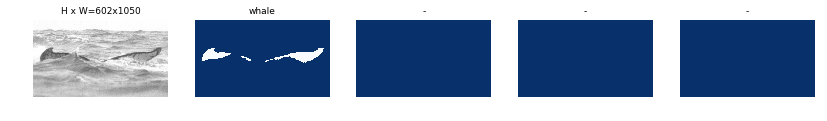

summask 124485.0


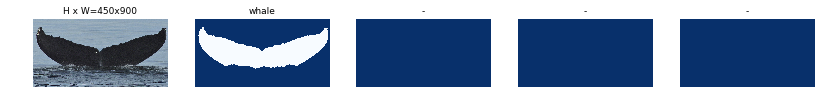

summask 208769.0


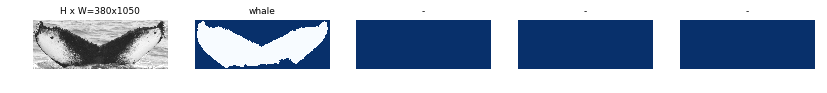

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print("summask",np.sum(np.sum(mask)))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 40


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')

KeyboardInterrupt: 

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")


Starting at epoch 32. LR=0.0001

Checkpoint Path: /mfs/tianyu/google/lyg/Mask_RCNN_test/Mask_RCNN/logs/whale20190123T1014/mask_rcnn_whale_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

/mfs/tianyu/env/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mfs/tianyu/env/local/lib/python2.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 33/40
300/300 [==============================] - 349s 1s/step - loss: 0.3398 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 2.1488e-04 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1043 - val_loss: 2.4305 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 2.1129 - val_mrcnn_class_loss: 1.8921e-04 - val_mrcnn_bbox_loss: 0.2052 - val_mrcnn_mask_loss: 0.1109
Epoch 34/40
300/300 [==============================] - 298s 993ms/step - loss: 0.4630 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.2418 - mrcnn_class_loss: 4.8968e-04 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1289 - val_loss: 4.9878 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 4.3860 - val_mrcnn_class_loss: 3.9872e-04 - val_mrcnn_bbox_loss: 0.4214 - val_mrcnn_mask_loss: 0.1773
Epoch 35/40
300/300 [==============================] - 424s 1s/step - loss: 0.3780 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1520 - mrcnn_class_loss: 3.5302e-04 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1200 - val_loss

In [9]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mfs/tianyu/google/lyg/Mask_RCNN_test/Mask_RCNN/logs/whale20190123T1014/mask_rcnn_whale_0040.h5
Re-starting from epoch 40


59 /home/tianyu/mfs/google/lyg/seg_data/train//image/03d494223.jpg
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1044.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   27.00000  max:  993.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  float64


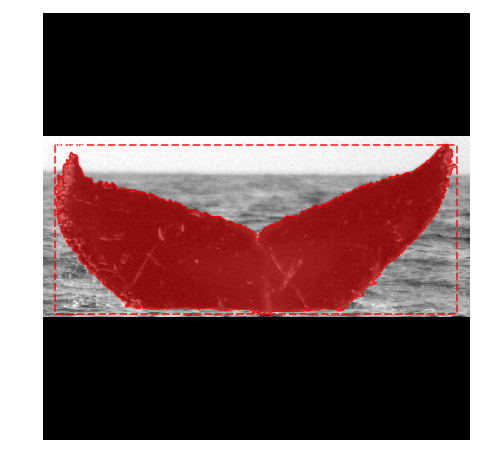

In [29]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 59
print(image_id,dataset_val.image_info[image_id]['path'])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),show_mask=True)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.13989  max:    1.07733  float32
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))


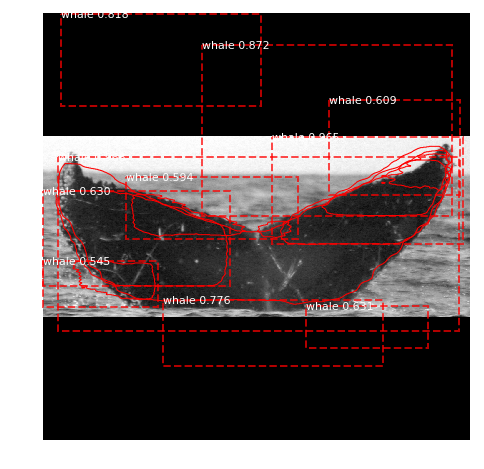

In [25]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(),show_mask=False)

## Evaluation

In [13]:
print("what are you doing")

what are you doing


train_ids_, ac27ad6a4.jpg
count, 25361
train_ids, ac27ad6a4
Processing 1 images
image                    shape: (582, 1050, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1050.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.13989  max:    1.07733  float32
('shift:', array([0.2228739, 0.       , 0.2228739, 0.       ], dtype=float32))
('scale:', array([0.55425215, 1.        , 0.55425215, 1.        ], dtype=float32))


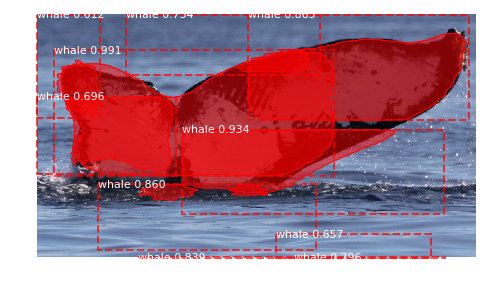

In [27]:
#predict in all data_train

predict_path='/home/tianyu/data-train/'
dataset_test = ShapesDataset()
dataset_test.load_shapes(predict_path)
dataset_test.prepare()

image_id = random.choice(dataset_test.image_ids)
original_image = dataset_test.load_image(59)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())


In [ ]:
# get the size of dataset_test
print("whether running...")

predict_ids_ = next(os.walk(predict_path+"/image/"))[2]
predict_ids = [ predict_ids_[i].replace(".jpg","") for i in range(len(predict_ids_)) ]

shape_test_image = []
i=0
for id_ in predict_ids:
    if i%1000==0:
        print([i,id_])
    img = skimage.io.imread(predict_path +'/image/' + id_ + '.jpg')
    shape_test_image.append(img.shape)
    i+=1

print("len(dataset_test.image_ids):",len(dataset_test.image_ids))

In [113]:
# test some parameter
print(len(shape_test_image))
# int(False)
# print(int(True))
# print(0*np.inf)
print(False*False)

25361
0


image_nani.shape (222, 1050, 3)
image.shape (222, 1050, 3)
('shift:', array([0.3939394, 0.       , 0.3939394, 0.       ], dtype=float32))
('scale:', array([0.2111437, 1.       , 0.2111437, 1.       ], dtype=float32))
r['masks'].shape (222, 1050, 1)
mask_re_.shape (222, 1050)


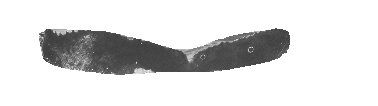

r['rois'] [[ 42   0 222 805]]


In [123]:
# test one instance
def apply_mask(image, mask,alpha=0.5):
    for c in range(3):
#         image[:, :, c] = np.where(mask == 1,image[:, :, c] *(1 - alpha) + alpha * 255,image[:, :, c])
        image[:, :, c] = np.where(mask != 1,255,image[:, :, c])
    return image

i=111
image = dataset_test.load_image(i)
# image = skimage.io.imread(dataset_test.image_info[i]['path'])
print("image_nani.shape",image_nani.shape)
print("image.shape",image.shape)
shape_0 = image.shape[0]
shape_1 = image.shape[1]
results = model.detect([image], verbose=0)
r = results[0]
masked_image = image.astype(np.uint32).copy()
# print("somemask",r['masks'][0][])
# print("sum",np.sum(r['masks'],1))
# print("max",np.max(r['masks']))
# print("min",np.min(r['masks']))
# print("rmask",r['masks'].shape)
mask_re_ = resize(r['masks'], (shape_0, shape_1), mode='constant', preserve_range = True)
mask_re_ = mask_re_[:,:,0]
# print("image.shape",image.shape)
print("r['masks'].shape",r['masks'].shape)
print("mask_re_.shape",mask_re_.shape)
# do masking
mask_result = apply_mask(masked_image, mask_re_)
# mask_result = np.ma.array(masked_image, mask=mask_re==True)
# print("summask_result",np.sum(mask_result))
# print("sumimage",np.sum(image))
# print("mask_re",mask_re.shape)
skimage.io.imshow(mask_result)
# fig = plt.figure()
# plt.axis('off')
# plt.imshow(mask_result)
# # plt.imshow(masked_image)
# plt.show()
print("r['rois']",r['rois'])



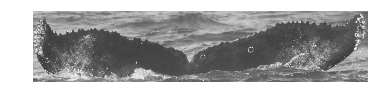

In [119]:
skimage.io.imshow(image)
# fig = plt.figure()
# plt.axis('off')
# # plt.imshow(mask_result)
# plt.imshow(image)
# plt.show()

In [ ]:
# run all images
# to save : the masked image, the bbox
def apply_mask(image, mask,alpha=0.5):
    for c in range(3):
#         image[:, :, c] = np.where(mask == 1,image[:, :, c] *(1 - alpha) + alpha * 255,image[:, :, c])
        image[:, :, c] = np.where(mask != 1,255,image[:, :, c])
    return image

pred_result_mask = []
pred_result_bbox = []
for i in range(len(dataset_test.image_ids)):
# for i in range(10):
#     if i%1000==0:
    print(i)
#     image = dataset_test.load_image(i)
#     image = skimage.io.imread(dataset_test.image_info[i]['path'])
    image = dataset_test.load_image(i)
    shape_0 = shape_test_image[i][0]
    shape_1 = shape_test_image[i][1]
    results = model.detect([image], verbose=0)
    r = results[0]
    masked_image = image.astype(np.uint32).copy()
    mask_re = resize(r['masks'], (shape_0, shape_1,), mode='constant', preserve_range = True)
    mask_re_= mask_re[:,:,0]
    mask_result = apply_mask(masked_image, mask_re_)
    skimage.io.imsave(predict_path+"/mask/"+predict_ids[i]+".jpg",mask_result)
#     fig = plt.figure()
#     plt.axis('off')
#     plt.imshow(mask_result)
#     plt.figure(figsize=(shape_0, shape_1))
#     plt.savefig(predict_path+"/mask/"+predict_ids[i]+".jpg")
#     print(predict_path+"/mask/"+predict_ids[i]+".jpg")
#     plt.close()
    pred_result_bbox.append(r['rois'])


In [132]:
print(len(pred_result_bbox[0][0]))

4


In [133]:

import pickle
pred_result_bbox_dic={}
for i in range(len(dataset_test.image_ids)):
    image_name=predict_ids[i]+".jpg"
    rois=[pred_result_bbox[i][0][x] for x in list([1,0,3,2])]
    pred_result_bbox_dic[image_name]=rois

output = open('/home/tianyu/mfs/google/bbox_test.pickle', 'wb')
pickle.dump(pred_result_bbox_dic, output)
output.close()

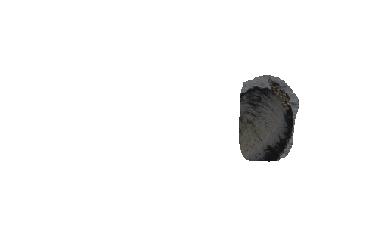

In [105]:
# show the image saved for test
from PIL import Image

fig = plt.figure()
image_path="/home/tianyu/data-train//mask/730459848.jpg"
img=Image.open(image_path)
img = np.array(img)
plt.axis('off')
plt.imshow(img)
plt.show()


In [106]:
# to save :the bbox

print(pred_result_bbox)



[array([[162,  42, 351, 840]], dtype=int32), array([[ 38,   0, 340, 543]], dtype=int32), array([[159,   0, 422, 927]], dtype=int32), array([[  0,  69, 228, 572]], dtype=int32), array([[  0, 325, 223, 883]], dtype=int32), array([[ 43, 645, 477, 989]], dtype=int32), array([[401, 346, 628, 947]], dtype=int32), array([[  0,   0, 194, 452]], dtype=int32), array([[  0,  47, 217, 866]], dtype=int32), array([[163,  26, 428, 819]], dtype=int32)]


In [67]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1.], dtype=float32))
('shift:', array([0., 0., 0., 0.], dtype=float32))
('scale:', array([1., 1., 1., 1